# Hands-on: Robustness

We consider a small social network of 34 members in a university karate club, called Zachary's karate club network.

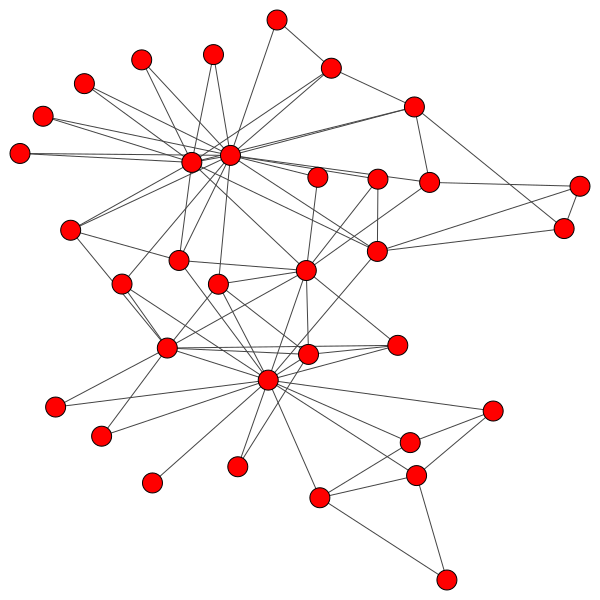

In [1]:
import igraph
g = igraph.Graph.Famous("Zachary")
igraph.plot(g, vertex_size=20)

Let's break the network 😈!
We will remove nodes one by one and see how the connectivity of the network changes at each step.
It is useful to create a copy of the network to keep the original network unchanged.

In [2]:
g_original = g.copy()

## Robustness against random failures

Let us remove a single node from the network. To this end, we need to first identify which nodes are in the network. With `igraph`, the IDs of the nodes in a graph are accessible through `Graph.vs.indices` as follows:

In [3]:
print(g.vs.indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


We randomly choose a node and remove it from the network by using `Graph.delete_vertices`.

In [4]:
import numpy as np
node_idx = np.random.choice(g.vs.indices)
g.delete_vertices(node_idx)
print("Node removed:", node_idx)
print("Nodes remaining:", g.vs.indices)

Node removed: 2
Nodes remaining: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


:::{note}
`np.random.choice(array)` takes an array `array` and returns a single element from the array.
For example, `np.random.choice(np.array([1, 2, 3]))` returns either 1, 2, or 3 with equal probability.
See [the documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) for more details.
:::

The connectivity of the network is the fraction of nodes in the largest connected component of the network after node removal.
We can get the connected components of the network by using `Graph.connected_components`.

In [5]:
components = g.connected_components()

The sizes of the connected components are accessible via `Graph.connected_components.sizes`.

In [6]:
components.sizes()

[33]

Thus, the connectivity of the network can be computed by

In [7]:
components = g.connected_components()
connectivity = np.max(components.sizes()) / g_original.vcount()
connectivity

0.9705882352941176

Putting together the above code, let us compute the robustness profile of the network.

In [8]:
import pandas as pd

g = g_original.copy() # restore the network
n_nodes = g.vcount()  # Number of nodes

results = []
for i in range(n_nodes -1):  # Loop if the network has at least one node

    # Remove a randomly selected node
    node_idx = np.random.choice(g.vs.indices)
    g.delete_vertices(node_idx)

    # Evaluate the connectivity
    components = g.connected_components()
    connectivity = np.max(components.sizes()) / g_original.vcount()

    # Save the results
    results.append(
        {
            "connectivity": connectivity,
            "frac_nodes_removed": (i + 1) / n_nodes,
        }
    )

df_robustness_profile = pd.DataFrame(results)

Let us plot the robustness profile.

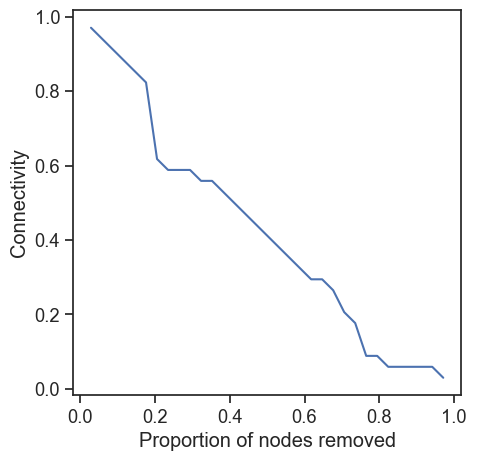

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', font_scale=1.2)
sns.set_style('ticks')

ax = df_robustness_profile.plot(
    x="frac_nodes_removed",
    y="connectivity",
    kind="line",
    figsize=(5, 5),
    label="Random attack",
)
plt.xlabel("Proportion of nodes removed")
plt.ylabel("Connectivity")
plt.legend().remove()
plt.show()

How should we interpret the robustness profile? Consider the most robust network consisting of $N$ nodes, where all $N$ nodes are fully connected. Regardless of how many nodes are removed, there will always be a single connected component, and the size of this component will be $N-k$ if $k$ nodes are removed. Therefore, the connectivity is $(N-k)/N=1-k/N$, which corresponds to the diagonal line in the plot above.
Hence, **a network is considered robust if its connectivity curve is close to the diagonal line**.
On the other hand, if the curve is significantly lower than the diagonal line, the network is not robust.

For the network we considered above, the robustness profile is close to the diagonal line, indicating that the network is robust to the random removal of nodes.

:::{note}
The random attack is stochastic, meaning that the robustness profile has a variation in each run. Thus, it is necessary to run the attack multiple times and average the results to get a more accurate estimate of the robustness.
:::

## Targeted attack

In a targeted attack, nodes are removed based on specific criteria rather than randomly.
One common strategy is to remove nodes from the largest node degree to the smallest, based on the idea that removing nodes with many edges is more likely to disrupt the network connectivity.

The degree of the nodes is accessible via `Graph.degree`.

In [10]:
print(g_original.degree())

[16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]


We compute the robustness profile by removing nodes with the largest degree and measuring the connectivity of the network after each removal.

In [11]:
g = g_original.copy() # restore the network
n_nodes = g.vcount()  # Number of nodes

results = []
for i in range(n_nodes -1):  # Loop if the network has at least one node

    # Remove the nodes with thelargest degree
    node_idx = g.vs.indices[np.argmax(g.degree())]
    g.delete_vertices(node_idx)

    # Evaluate the connectivity
    components = g.connected_components()
    connectivity = np.max(components.sizes()) / g_original.vcount()

    # Save the results
    results.append(
        {
            "connectivity": connectivity,
            "frac_nodes_removed": (i + 1) / n_nodes,
        }
    )

df_robustness_profile_targeted = pd.DataFrame(results)

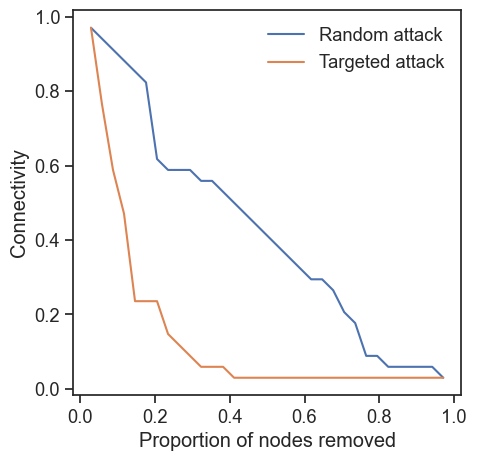

In [12]:
sns.set(style='white', font_scale=1.2)
sns.set_style('ticks')

sns.set(style="white", font_scale=1.2)
sns.set_style("ticks")

ax = df_robustness_profile.plot(
    x="frac_nodes_removed",
    y="connectivity",
    kind="line",
    figsize=(5, 5),
    label="Random attack",
)
ax = df_robustness_profile_targeted.plot(
    x="frac_nodes_removed",
    y="connectivity",
    kind="line",
    label="Targeted attack",
    ax=ax,
)
ax.set_xlabel("Proportion of nodes removed")
ax.set_ylabel("Connectivity")
ax.legend(frameon=False)
plt.show()

While the network is robust against the random attacks, it is vulnerable to the degree-based targeted attack.

The **$R$-index** is the area under the connectivity curve, which can be computed by

In [13]:
rindex = df_robustness_profile["connectivity"].mean()
rindex_targeted = df_robustness_profile_targeted["connectivity"].mean()
print(f"R-index (random): {rindex:.3f}")
print(f"R-index (targeted): {rindex_targeted:.3f}")

R-index (random): 0.425
R-index (targeted): 0.140


The targeted attack has a smaller $R$-index, indicating that the network is less robust to the targeted attack compared to the random attack.